#Dataset Preprocessing

In [ ]:
import os
import random
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Source dataset: from where to copy the files
sourceFolderClass1 = '/content/drive/MyDrive/cropped/polyps'
sourceFolderClass2 = '/content/drive/MyDrive/cropped/non_polyps'
# Destination folders: splitted dataset in train and validation for polyps and non-polyps
destFolderClass1_tr  = '/content/drive/MyDrive/data_polyps/train/polyps'
destFolderClass2_tr  = '/content/drive/MyDrive/data_polyps/train/non_polyps'
destFolderClass1_val = '/content/drive/MyDrive/data_polyps/validation/polyps'
destFolderClass2_val = '/content/drive/MyDrive/data_polyps/validation/non_polyps'

In [ ]:
sourceFiles1 = os.listdir(sourceFolderClass1)
sourceFiles2 = os.listdir(sourceFolderClass2)
print("Class 1 - polyps:", len(sourceFiles1))
print("Class 2 - non-polyps:", len(sourceFiles2))

Class 1 - polyps: 606
Class 2 - non-polyps: 606


In [ ]:
random.seed(1)
random.shuffle(sourceFiles1)
random.shuffle(sourceFiles2)

In [ ]:
# No of file to copy in VALIDATION folder for each class
val_files = 151
import shutil
# Copy the first 151 files for polyps and non-polyps into validation folders
print('--> Validation split ...')
for i in range(val_files):
    # copy validation polyps
    File1 = os.path.join(sourceFolderClass1, sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_val,  sourceFiles1[i])
    shutil.copy(File1,File2)
    # copy validation non-polyps
    File1 = os.path.join(sourceFolderClass2, sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_val,   sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Validation split ...
--> Done!


In [ ]:
# Copy polyps to train
print('--> Train split ...')
for i in range(val_files,len(sourceFiles1)):
    File1 = os.path.join(sourceFolderClass1,  sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_tr, sourceFiles1[i])
    shutil.copy(File1,File2)

# copy non-polyps to train
for i in range(val_files,len(sourceFiles2)):
    File1 = os.path.join(sourceFolderClass2,  sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_tr, sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Train split ...
--> Done!


In [ ]:
print('--> Dataset: data_polyps')
print('> Train - polyps:', len(os.listdir(destFolderClass1_tr)))
print('> Train - non-polyps:', len(os.listdir(destFolderClass2_tr)))
print('> Validation - polyps:', len(os.listdir(destFolderClass1_val)))
print('> Validation - non-polyps:', len(os.listdir(destFolderClass2_val)))

--> Dataset: data_polyps
> Train - polyps: 455
> Train - non-polyps: 455
> Validation - polyps: 151
> Validation - non-polyps: 151


#Classification using DNN

In [ ]:
import keras

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow.random import set_seed

import time, os
from __future__ import with_statement

%matplotlib inline

In [ ]:
class PlotLosses(keras.callbacks.Callback):
    # Show the live training and validation loss during the training
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="ACC_Train")
        plt.plot(self.x, self.val_acc, label="ACC_Val")
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0.)
        plt.grid()
        # plt.ylim(0.0, 1.0) # limited Y values to 1.0!
        plt.show()

plot_losses = PlotLosses() # initialize the class

In [ ]:
# Dimensions of our images.
img_width, img_height = 150, 150

# Train & validation folders
train_data_dir      = '/content/drive/MyDrive/data_polyps/train'
validation_data_dir = '/content/drive/MyDrive/data_polyps/validation'

# Folder to save the models
modelFolder = '/content/drive/MyDrive/saved_models'

# Train parameters
nb_train_samples      = 910
nb_validation_samples = 302

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

##Small CNNs: 1 Conv + 1 FC

In [ ]:
def CNN_1Conv_1FC(convs, dims, epochs, batch_size, input_shape):
    # CNN with 1 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs

    # for reproductibility
    #seed(74)            # numpy seed
    #set_random_seed(74) # tensorflow seed

    # Start the computational graph for our CNN
    model = Sequential()

    # CNN filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])

    return model # return the model!

**A CNN with 32 filter of 3 x 3 pixels**

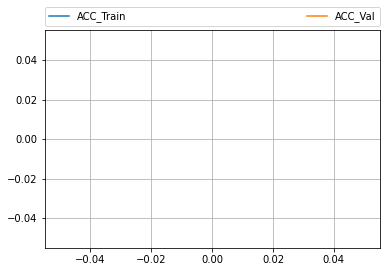

<ipython-input-19-30090280c160>:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.44806477427482605
Validation/Test accuracy: 0.8125
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten_10 (Flatten)        (None, 175232)            0         
                                                                 
 dense_20 (Dense)            (None, 32)                5607456   
                                                                 
 activation_1 (Activation)   (None, 32) 

In [ ]:
print('--> Training Conv-FC ver 1 ...')
model = CNN_1Conv_1FC(convs=32, dims=3, epochs=50, batch_size=64, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_1_Conv-FC_weigths.h5'))
print('Done!')

Conclusion: with a Conv + FC topology with 32 filters of 3 x 3 pixels, we are able to obtain in 50 epochs a classifier with  81% test accuracy for the polyps vs non-polyps prediction!

**A second CNN with filter of 5 x 5 pixels:**

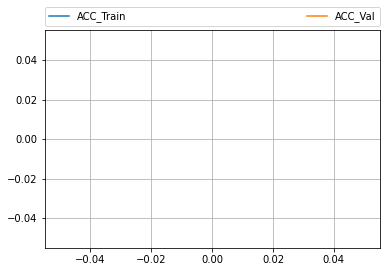

<ipython-input-10-30090280c160>:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.6930910348892212
Validation/Test accuracy: 0.515625
---> Save model ...
Done!


In [ ]:
print('--> Training Conv-FC ver 2 ...')
model = CNN_1Conv_1FC(convs=32, dims=5, epochs=50, batch_size=64, input_shape= input_shape)
# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_2_Conv-FC_weigths.h5'))
print('Done!')

Conclusion: in the case of the Conv + FC topology, 32 filters 5 x 5 we can obtain less than 60% accuracy in 50 epochs (5,459,393 parameters). This means bigger filters are not able to find the best patterns for this classification.

**A CNN with 64 filter of 3 x 3 pixels**

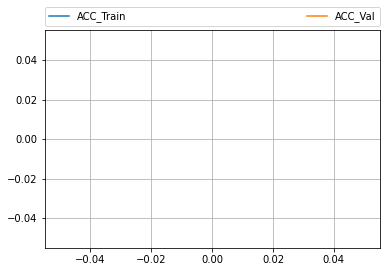

<ipython-input-36-30090280c160>:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.4720505177974701
Validation/Test accuracy: 0.8046875
---> Save model ...
Done!


In [ ]:
print('--> Training Conv-FC ver 3 ...')
model = CNN_1Conv_1FC(convs=64, dims=3, epochs=100, batch_size=64, input_shape= input_shape)
# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_3_Conv-FC_weigths.h5'))
print('Done!')


**A CNN with 128 filter of 3 x 3 pixels**

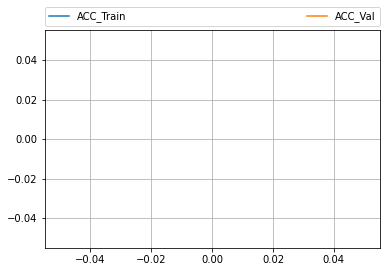

<ipython-input-36-30090280c160>:68: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.4944918155670166
Validation/Test accuracy: 0.79296875
---> Save model ...
Done!


In [ ]:
print('--> Training Conv-FC ver 4 ...')
model = CNN_1Conv_1FC(convs=128, dims=3, epochs=100, batch_size=64, input_shape= input_shape)
# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_4_Conv-FC_weigths.h5'))
print('Done!')

##Small CNNs: 2 Conv + 1 FC

In [ ]:
def CNN_2Conv_1FC(convs, dims, epochs, batch_size, input_shape):
    # CNN with 2 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs

    # for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed

    # Start the computational graph for our CNN
    model = Sequential()

    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 2 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer= 'adam', # 'rmsprop',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])

    return model # return the model!

**32 filters - 64 filters - 64 FC**

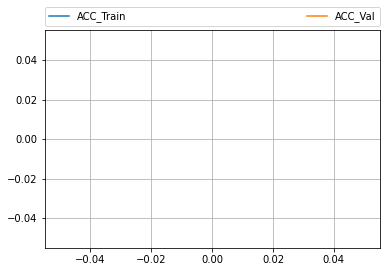

<ipython-input-43-3ce0b7050160>:73: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.3792693614959717
Validation/Test accuracy: 0.8671875
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36

In [ ]:
print('--> Training Conv-Conv-FC ver 1 ...')
model = CNN_2Conv_1FC(convs=32, dims=3, epochs=50, batch_size=64, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model2_1_Conv-Conv-FC_weigths.h5'))
print('Done!')

Conclusions: By adding the second Conv layer we can see accuracy improvment to over 85% using 5,327,937 parameters.

**Conv 64 - Conv 128 - FC**

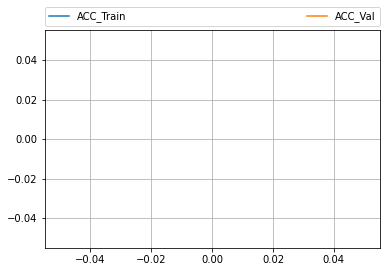

<ipython-input-43-3ce0b7050160>:73: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.5085585713386536
Validation/Test accuracy: 0.8203125
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 activation_16 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 activation_17 (Activation)  (None, 72, 72, 128)       0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36

In [ ]:
print('--> Training Conv-Conv-FC ver 2 ...')
model = CNN_2Conv_1FC(convs=64, dims=3, epochs=50, batch_size=64, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model2_2_Conv-Conv-FC_weigths.h5'))
print('Done!')

Conclusions: By doubling the number of filters for Conv-Conv-FC with 21,309,569 parameters no better results are obtained.

##Small CNNs: 3 Conv - 1FC

In [ ]:
def CNN_3Conv_1FC(convs, dims, epochs, batch_size, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs

    # for reproductibility
    # seed(1)            # numpy seed
    # set_random_seed(2) # tensorflow seed

    # Start the computational graph for our CNN
    model = Sequential()

    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])

    return model # return the model!

**Conv-Conv-Conv-FC with 32, 32 and 64 filters (3 x 3)**

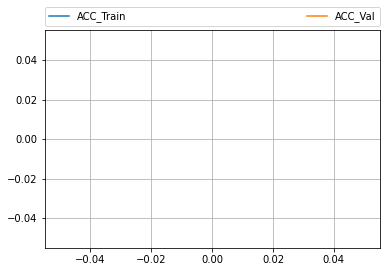

<ipython-input-48-4dee4738e474>:78: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.3797749876976013
Validation/Test accuracy: 0.859375
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_21 (Activation)  (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36,

In [ ]:
print('--> Training Conv-Conv-Conv-FC ver 1 ...')
model = CNN_3Conv_1FC(convs=32, dims=3, epochs=50, batch_size=64, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model3_1_Conv-Conv-Conv-FC_weigths.h5'))
print('Done!')

**Conv-Conv-Conv-FC with double number of filters: 64, 64 and 128 filters (3 x 3)**

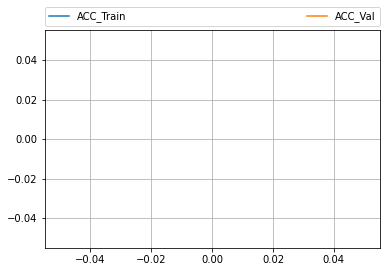

<ipython-input-48-4dee4738e474>:78: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.32850998640060425
Validation/Test accuracy: 0.87890625
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_25 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 activation_26 (Activation)  (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 

In [ ]:
print('--> Training Conv-Conv-Conv-FC ver 2 ...')
model = CNN_3Conv_1FC(convs=64, dims=3, epochs=50, batch_size=64, input_shape= input_shape)

print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model3_2_Conv-Conv-Conv-FC_weigths.h5'))
print('Done!')

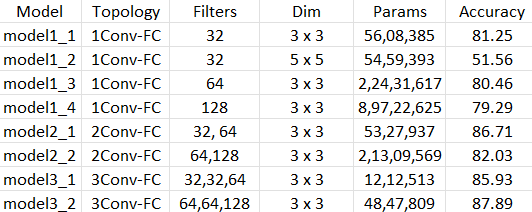

**let's see what we can have in 100 iterations**

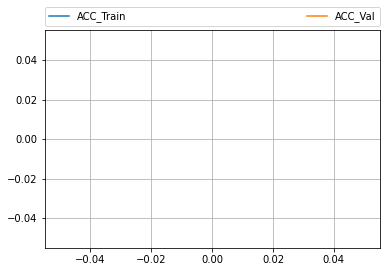

<ipython-input-48-4dee4738e474>:78: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.3228839933872223
Validation/Test accuracy: 0.890625
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_30 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 activation_31 (Activation)  (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 36,

In [ ]:
print('--> Training Conv-Conv-Conv-FC ver 3 ...')
model = CNN_3Conv_1FC(convs=64, dims=3, epochs=100, batch_size=64, input_shape= input_shape)

print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model3_3_Conv-Conv-Conv-FC_weigths.h5'))
print('Done!')

##Hyperparameter optimization for 3 Conv - FC

In [ ]:
def CNN_3Conv_1FC_optim(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # drop_rate = dropout of neurons
    # activFunction = 'relu', 'tanh', etc.
    # input_shape = shape of the inputs

    # for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed

    # Start the computational graph for our CNN
    model = Sequential()

    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation(activFunction))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation(activFunction))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation(activFunction))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation(activFunction))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose=0,
        workers=7) # using multi-cpu!

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    return (score[0],score[1]) # test loss and accuracy

In [ ]:
# Search for the best hyperparameters:  batch size and drop rate
print('--> Search for the best hyperparameters: batch size and drop rate ...')

# Fixed params from the best model in Search 1
convs = 64
dims = 3
epochs = 50
activFunction = 'relu'
optimizer = 'Adam'
print('Fixed params - Filters, Filter size, Epochs, Activations, Optimizer:', convs, dims, epochs, activFunction, optimizer)

# Grid search for parameters
batch_sizeGrid = [8, 16, 32, 64, 128]
drop_rateGrid  = [0.1, 0.5, 0.9]
print('Searching params - Batch size, Drop rate', batch_sizeGrid, drop_rateGrid)

# Start total timer
start_time = time.time()

# get all the results as list
results = []
for batch_size in batch_sizeGrid:
    for drop_rate in drop_rateGrid:
        # timer for each iteration
        istart_time = time.time()
        # get Loss and Accuracy for CNN Conv-Conv-Conv-FC with specific parameters
        iLoss, iAccuracy = CNN_3Conv_1FC_optim(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, input_shape)
        # append the results to a list
        results.append([convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, iLoss, iAccuracy])
        # print for each iteration the results and the iteration time
        print(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, iLoss, iAccuracy)
        print("--> Iter time: %0.1f mins ---" % ((time.time() - istart_time) / 60))

# Print total time for the parameter search
print("Done! Total time: %0.1f mins ---" % ((time.time() - start_time)/60))

--> Search for the best hyperparameters: batch size and drop rate ...
Fixed params - Filters, Filter size, Epochs, Activations, Optimizer: 64 3 50 relu Adam
Searching params - Batch size, Drop rate [8, 16, 32, 64, 128] [0.1, 0.5, 0.9]
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


<ipython-input-21-d6265ad873fe>:70: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
<ipython-input-21-d6265ad873fe>:80: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


64 3 50 8 0.1 relu Adam 0.44947999715805054 0.8108108043670654
--> Iter time: 4.8 mins ---
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
64 3 50 8 0.5 relu Adam 0.35991019010543823 0.8716216087341309
--> Iter time: 4.8 mins ---
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
64 3 50 8 0.9 relu Adam 0.4238831400871277 0.8243243098258972
--> Iter time: 4.9 mins ---
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
64 3 50 16 0.1 relu Adam 0.32468563318252563 0.8784722089767456
--> Iter time: 4.6 mins ---
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
64 3 50 16 0.5 relu Adam 0.37057799100875854 0.8541666865348816
--> Iter time: 4.6 mins ---
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
64 3 50 16 0.9 relu Adam 0.5438511967658997 0.7395833134651184
--> Iter time: 4.7 mins ---
Found 910 images belonging to 2 classes.
Fo

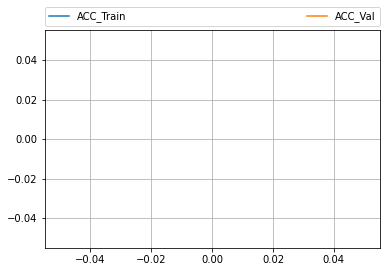

<ipython-input-24-4dee4738e474>:78: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Validation/Test loss    : 0.31709587574005127
Validation/Test accuracy: 0.9140625
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_78 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 activation_79 (Activation)  (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 

In [ ]:
print('--> Training best model for Small CNNs: Conv-Conv-Conv-FC ...')
model = CNN_3Conv_1FC(convs=64, dims=3, epochs=200, batch_size=64, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model_best_Conv-Conv-Conv-FC_weigths.h5'))
model.save(os.path.join(modelFolder,'model_best_Conv-Conv-Conv-FC_full.h5'))
print('Done!')

In [ ]:
def CNN_3Conv_1FCv2(convs, dims, epochs, batch_size, drop_rate, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # drop_rate = drop rate (0, 1.0) <---- added
    # input_shape = shape of the inputs

    # for reproductibility
    # seed(1)            # numpy seed
    # set_random_seed(2) # tensorflow seed

    # Start the computational graph for our CNN
    model = Sequential()

    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score_val = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    score_tr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)
    print('Train loss    :', score_tr[0])
    print('Train accuracy:', score_tr[1])
    print('Validation loss    :', score_val[0])
    print('Validation accuracy:', score_val[1])

    return model # return the model!

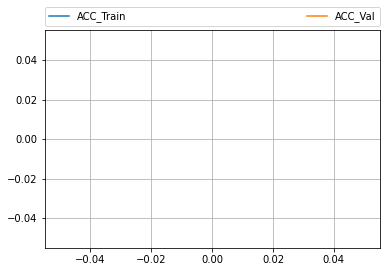

<ipython-input-12-dd45707a0f59>:79: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_val = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
<ipython-input-12-dd45707a0f59>:80: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_tr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)


Train loss    : 0.11473869532346725
Train accuracy: 0.953125
Validation loss    : 0.2236955165863037
Validation accuracy: 0.91015625
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 activation_3 (Activation)   (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 activation_4 (Activation)   (None, 72, 72, 64)        0         
                                                     

In [ ]:
print('--> Training best model for Small CNNs: Conv-Conv-Conv-FC ...')
model = CNN_3Conv_1FCv2(convs=64, dims=3, epochs=400, batch_size=64,
                        drop_rate=0.9, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model_best2_Conv-Conv-Conv-FC_weigths.h5'))
model.save(os.path.join(modelFolder,'model_best2_Conv-Conv-Conv-FC_full.h5'))
print('Done!')

# VGG16 Transfer Learning

In [ ]:
import keras

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow.random import set_seed

import time, os
from __future__ import with_statement

%matplotlib inline

In [ ]:
# Dimensions of our images
img_width, img_height = 150, 150

# Train & validation folders
train_data_dir      = '/content/drive/MyDrive/data_polyps/train'
validation_data_dir = '/content/drive/MyDrive/data_polyps/validation'

# Folder to save the models
modelFolder = '/content/drive/MyDrive/saved_models'

# Sample parameters
nb_train_samples      = 910 # number of training images (all classes)
nb_validation_samples = 302 # number of validation images (all classes)

# Initial training params from the previous small CNN script
epochs     = 50 # training epochs
batch_size = 64 # batch size for training

In [ ]:
# Training results for our dataset using pre-trained VGG16 (Convolutional layers only, without top FC)
bottleneck_features_train_path = '/content/drive/MyDrive/saved_models/transferVGG16_bottleneck_features_train.npy'

# Validation results for our dataset using pre-trained VGG16 (Convolutional layers only, without top FC)
bottleneck_features_validation_path = '/content/drive/MyDrive/saved_models/transferVGG16_bottleneck_features_validation.npy'

# Top top model weights to used for future calculations for layer initialization
top_model_weights_path = '/content/drive/MyDrive/saved_models/transferVGG16_bottleneck_fc_model.h5'

# Earlystoping saved model
earlystoping_path = '/content/drive/MyDrive/saved_models/transferVGG16_earlystop_model.h5'

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

##Calculate the outputs of bottom VGG model for training and validation

In [ ]:
def save_bottlebeck_features(batch_size):
    # Calculate the outputs for training and validations sets using bottom pre-trained VGG16
    # Input: batch_size - it will be used to save to file
    # Output: number of the examples for the saved outputs (it could be different from the original dataset!)

    # set numpy and tensorflow seeds for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed

    # No data augmentation!
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Build the VGG16 network - get VGG16 trained for imagenet without the top layer
    model = applications.VGG16(include_top=False, weights='imagenet')

    # Generate training data from train folder
    # generator = datagen.flow_from_directory(
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Calculate the output of bottom VGG16 using training data
    bottleneck_features_train = model.predict_generator(
            generator, nb_train_samples // batch_size)
    # Save the traing outputs
    np.save(bottleneck_features_train_path, bottleneck_features_train)

    # Generate validation data from train folder
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Calculate the output of bottom VGG16 using validation data
    bottleneck_features_validation = model.predict_generator(
            generator, nb_validation_samples // batch_size)

    # Save the validation outputs
    np.save(bottleneck_features_validation_path, bottleneck_features_validation)
    return (bottleneck_features_train.shape[0], bottleneck_features_validation.shape[0]) # return the new shapes if modified

In [ ]:
nb_train_samples, nb_validation_samples = save_bottlebeck_features(batch_size=64)

Found 910 images belonging to 2 classes.


<ipython-input-23-09e5536dbb8f>:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = model.predict_generator(


Found 302 images belonging to 2 classes.


<ipython-input-23-09e5536dbb8f>:40: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = model.predict_generator(


In [ ]:
print('New no of train samples      = ', nb_train_samples)
print('New no of validation samples = ', nb_validation_samples)

New no of train samples      =  896
New no of validation samples =  256


##Train the top FC model by using the outputs from the pre-trained bottom VGG16

In [ ]:
class PlotLosses(keras.callbacks.Callback):
    # Show the live training and validation loss during the training
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="ACC_Train")
        plt.plot(self.x, self.val_acc, label="ACC_Val")
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0.)
        plt.grid()
        plt.show()

plot_losses = PlotLosses() # initialize the class

In [ ]:
def train_top_model(epochs, batch_size, optimizer, drop_rate, callbacks, summary):
    # Training top model
    # Input:
    # - epochs = no of training epochs
    # - batch_size = size of sample batch during training
    # - optimizer = string to define the optimizer (ex: 'adam', 'optimizers.RMSprop(lr=2e-4)')
    # - drop_rate = rate of dropped neurons
    # - callbacks = list of callbacks options
    # - summary = if True, show the model summary (True, False)

    # set numpy and tensorflow seeds for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed

    # Load training outputs from the pre-trained bottom VGG16
    train_data   = np.load(bottleneck_features_train_path)
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    # Load training outputs from the pre-trained bottom VGG16
    validation_data   = np.load(bottleneck_features_validation_path)
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    # Construct the top model using two parts: outputs from the bottom VGG16 + a FC layer
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the graph
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the model using the live plot of the loss
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose = 0,
              callbacks=callbacks)
    # Save the final model
    model.save_weights(top_model_weights_path)

    # Print model summary
    if summary == True:
        model.summary()

    # Evaluate final test loss and accuracy scores
    score_val = model.evaluate(validation_data, validation_labels, verbose=0)
    score_tr  = model.evaluate(train_data, train_labels, verbose=0)
    print('Train loss    :', score_tr[0])
    print('Train accuracy:', score_tr[1])
    print('Validation loss    :', score_val[0])
    print('Validation accuracy:', score_val[1])

**Traing the FC model using epochs = 50, batch_size = 64, optimizer = 'adam'**

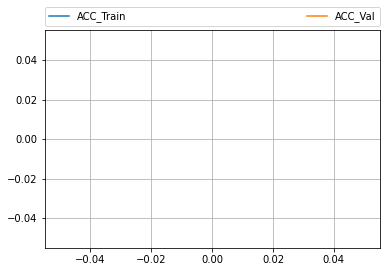

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Train loss    : 0.006215565372258425
Train accuracy: 0.9988839030265808
Validation loss    : 1.0382908582687378
Validation accuracy: 0.8515625


In [ ]:
epochs     = 50
batch_size = 64 # this value should be the same with the one used for save_bottlebeck_features()
optimizer  = 'adam'
drop_rate  = 0.5
callbacks  = [plot_losses]
summary    = True # for the first time show the summary of the trained top model

train_top_model(epochs, batch_size, optimizer, drop_rate, callbacks, summary)

**The overfitting is huge. So, tried to apply more regularization by increasing the drop rate to 0.9**

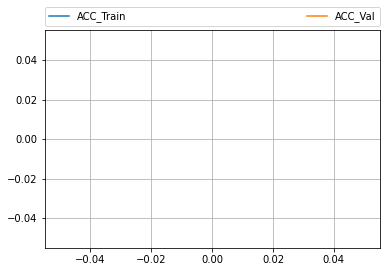

Train loss    : 0.11610683053731918
Train accuracy: 0.9665178656578064
Validation loss    : 0.6419205069541931
Validation accuracy: 0.80859375


In [ ]:
epochs     = 50
batch_size = 64 # this value should be the same with the one used for save_bottlebeck_features()
optimizer  = 'adam'
drop_rate  = 0.9
callbacks  = callbacks=[plot_losses]
summary    = False # for the first time show the summary of the trained top model

nb_train_samples, nb_validation_samples = save_bottlebeck_features(batch_size)
train_top_model(epochs, batch_size, optimizer, drop_rate, callbacks, summary)

**Conclusion: With increased drop rate, the overfitting is decreasing but results are not better than the previous small CNN.**




# VGG16 fine tuning

In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from numpy.random import seed
from tensorflow.random import set_seed
import time, os
import numpy as np
import keras

from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score
from __future__ import with_statement
%matplotlib inline

In [ ]:
# Folder to save the models
modelFolder = '/content/drive/MyDrive/saved_models'

# Path to the file with the weights of the pre-trained VGG16 model
weights_path = '/content/drive/MyDrive/nets/vgg16_weights.h5'

# Path to the previous saved top model weights (FC layer trained in Transfer Learning notebook)
top_model_weights_path = os.path.join(modelFolder,'transferVGG16_bottleneck_fc_model.h5')

# Earlystoping saved model - this name will be modified later by including parameter values
earlystoping_path = '/content/drive/MyDrive/saved_models/fineTunning_earlystopnning.h5'

# Dimensions of our images
img_width, img_height = 150, 150

# Train & validation images folders
train_data_dir      = '/content/drive/MyDrive/data_polyps/train'
validation_data_dir = '/content/drive/MyDrive/data_polyps/validation'

# Train parameters
nb_train_samples      = 910 # number of samples for training
nb_validation_samples = 302 # number of samples for validation
epochs = 300
batch_size = 16

In [ ]:
def FineTunningVGG(epochs, batch_size, learning, mom, freezeLayers):
    # Fine tuning function using VGG16 and our weights for the FC layer (top model)

    # Set seeeds for reproductibility
    # seed(1)            # numpy seed
    # set_random_seed(2) # tensorflow seed

    # Build the VGG16 block using our input size 150, 150, 3
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

    # Build a classifier model to put on top of the convolutional model (FC layer / top model)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    # Is necessary to start with a fully-trained classifier, including the top classifier,
    # in order to successfully do fine-tuning

    # Load the previous calculated weight for the top model
    top_model.load_weights(top_model_weights_path)

    # Add the model on top of the convolutional base
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

    # Set the first 'freezeLayers' layers to non-trainable (weights will not be updated)
    # This number depends on the blocks to freeze: for the last Conv block freeze 15 layers,
    # to freeze 2 last conv blocks freeze only 11 layers.
    for layer in model.layers[:freezeLayers]:
        layer.trainable = False

    # Compile the model with a SGD/momentum optimizer and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer= optimizers.SGD(lr=learning, momentum=mom), # lr=1e-4, momentum=0.9
                  metrics=['accuracy'])

    # Prepare data augmentation configuration
    train_datagen = ImageDataGenerator(
        rescale = 1. / 255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 90)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    # Generate training and validation data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    # Start timer
    start_time = time.time()

    # Use earlystopping:
    callbacks=[EarlyStopping(
                            monitor='val_acc',
                            patience=10,
                            mode='max',
                            verbose=1),
                ModelCheckpoint(earlystoping_path[:-3]+'_e'+str(epochs)+'b'+str(batch_size)+'l'+str(learning)+'m'+str(mom)+'f'+str(freezeLayers)+'.h5',
                            monitor='val_acc',
                            save_best_only=True,
                            mode='max',
                            verbose=0)]

    # Fine-tune the model
    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        workers=7, # 7 cores of the CPU!
        verbose = 0,
        callbacks=callbacks) # remove this param if you dont need early stopping

    # Print training time
    print("Training time: %0.1f mins ---" % ((time.time() - start_time)/60))

    # Evaluate final test loss and accuracy scores
    scoresVal = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    scoresTr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)
    # Print the results
    print(freezeLayers, learning, mom, epochs, batch_size, scoresTr[0], scoresVal[0], scoresTr[1], scoresVal[1])

    # clean some memory
    del base_model
    del top_model
    del model

    del train_datagen
    del train_generator
    del validation_generator

    return

##Last Conv block + FC training

In [ ]:
FineTunningVGG(200, 64, 1e-4,  0.9, 15)

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
<ipython-input-12-2ac6e724cc43>:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


<ipython-input-12-2ac6e724cc43>:92: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresVal = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Training time: 22.6 mins ---


<ipython-input-12-2ac6e724cc43>:93: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresTr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)


15 0.0001 0.9 200 64 0.0548800490796566 0.2249465435743332 0.9776785969734192 0.92578125


In [ ]:
# Start total timer
start_time = time.time()

# Change your hyperparamters to search for
freezeLayersValues = [15] # 15 = freeze last Conv block, 11 = freeze last 2 Conv blocks
learningValues = [1e-6, 1e-5, 1e-4, 5e-4, 1e-3]
monValues = [0.8, 0.9]
epochsValues = [100]
batch_sizeValues = [64]

# Print a header for results
print('Freeze', 'Learning', 'Momentum', 'epochs', 'batch_size', 'Loss_Tr', 'Loos_Val', 'Acc_Tr', 'Acc_Val')
for freezeLayers in freezeLayersValues: #
    for learning in learningValues:
        for mom in monValues:
            for iepochs in epochsValues:
                for ibatch_size in batch_sizeValues:
                    try:
                        # Try to execute the fine tuning function
                        FineTunningVGG(iepochs, ibatch_size, learning, mom, freezeLayers)
                    except:
                        # If any error
                        print('==> Error:', freezeLayers, learning, mom, iepochs, ibatch_size)

# Print total execution time
print("Total time: %0.1f mins ---" % ((time.time() - start_time)/60))

Freeze Learning Momentum epochs batch_size Loss_Tr Loos_Val Acc_Tr Acc_Val
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


<ipython-input-53-2ac6e724cc43>:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
<ipython-input-53-2ac6e724cc43>:92: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresVal = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Training time: 10.7 mins ---


<ipython-input-53-2ac6e724cc43>:93: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresTr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)


15 1e-06 0.8 100 64 0.3102264106273651 0.251343309879303 0.8616071343421936 0.90234375
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 10.5 mins ---
15 1e-06 0.9 100 64 0.33457151055336 0.25805747509002686 0.8716517686843872 0.8984375
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 10.8 mins ---
15 1e-05 0.8 100 64 0.24862666428089142 0.2526574432849884 0.8928571343421936 0.9140625
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 10.5 mins ---
15 1e-05 0.9 100 64 0.21927884221076965 0.23870259523391724 0.9107142686843872 0.93359375
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 10.9 mins ---
15 0.0001 0.8 100 64 0.15930747985839844 0.28220754861831665 0.9330357313156128 0.88671875
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 10.7 mins ---
15 0.0001 0.9 100 64 0.08805334568023682 0.20028090476989746 0.9709821343421936 0.9375
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


**With learning rate=0.0005 and momentum=0.9**

In [ ]:
# Start total timer
start_time = time.time()

# Change your hyperparamters to search for
freezeLayersValues = [15] # 15 = freeze last Conv block, 11 = freeze last 2 Conv blocks
learningValues = [2e-4, 3e-4, 4e-4, 6e-4, 7e-4]
monValues = [0.9]
epochsValues = [100]
batch_sizeValues = [64]

# Print a header for results
print('Freeze', 'Learning', 'Momentum', 'epochs', 'batch_size', 'Loss_Tr', 'Loos_Val', 'Acc_Tr', 'Acc_Val')
for freezeLayers in freezeLayersValues: #
    for learning in learningValues:
        for mom in monValues:
            for iepochs in epochsValues:
                for ibatch_size in batch_sizeValues:
                    try:
                        # Try to execute the fine tuning function
                        FineTunningVGG(iepochs, ibatch_size, learning, mom, freezeLayers)
                    except:
                        # If any error
                        print('==> Error:', freezeLayers, learning, mom, iepochs, ibatch_size)

# Print total execution time
print("Total time: %0.1f mins ---" % ((time.time() - start_time)/60))

Freeze Learning Momentum epochs batch_size Loss_Tr Loos_Val Acc_Tr Acc_Val
58889256/58889256 [==============================] - 3s 0us/step
==> Error: 15 0.0002 0.9 100 64
==> Error: 15 0.0003 0.9 100 64
==> Error: 15 0.0004 0.9 100 64
==> Error: 15 0.0006 0.9 100 64
==> Error: 15 0.0007 0.9 100 64
Total time: 0.1 mins ---


##Last 2 Conv block + FC training

In [ ]:
FineTunningVGG(100, 64, 1e-4,  0.9, 11)

Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


<ipython-input-12-2ac6e724cc43>:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(
<ipython-input-12-2ac6e724cc43>:92: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresVal = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Training time: 11.3 mins ---


<ipython-input-12-2ac6e724cc43>:93: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresTr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)


11 0.0001 0.9 100 64 0.07739340513944626 0.1704360544681549 0.9720982313156128 0.91796875


In [ ]:
# Start total timer
start_time = time.time()

# Change your hyperparamters to search for
freezeLayersValues = [11] # 15 = freeze last Conv block, 11 = freeze last 2 Conv blocks
learningValues = [1e-6, 1e-5, 1e-4, 5e-4]
monValues = [0.8, 0.9]
epochsValues = [100]
batch_sizeValues = [64]

# Print a header for results
print('Freeze', 'Learning', 'Momentum', 'epochs', 'batch_size', 'Loss_Tr', 'Loos_Val', 'Acc_Tr', 'Acc_Val')
for freezeLayers in freezeLayersValues: #
    for learning in learningValues:
        for mom in monValues:
            for iepochs in epochsValues:
                for ibatch_size in batch_sizeValues:
                    try:
                        # Try to execute the fine tuning function
                        FineTunningVGG(iepochs, ibatch_size, learning, mom, freezeLayers)
                    except:
                        # If any error
                        print('==> Error:', freezeLayers, learning, mom, iepochs, ibatch_size)

# Print total execution time
print("Total time: %0.1f mins ---" % ((time.time() - start_time)/60))

Freeze Learning Momentum epochs batch_size Loss_Tr Loos_Val Acc_Tr Acc_Val
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


<ipython-input-12-2ac6e724cc43>:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


==> Error: 11 1e-06 0.8 100 64
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
==> Error: 11 1e-06 0.9 100 64
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
==> Error: 11 1e-05 0.8 100 64
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
==> Error: 11 1e-05 0.9 100 64
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


<ipython-input-12-2ac6e724cc43>:92: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresVal = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)


Training time: 11.9 mins ---


<ipython-input-12-2ac6e724cc43>:93: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scoresTr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)


11 0.0001 0.8 100 64 0.061438631266355515 0.2073000967502594 0.9799107313156128 0.94140625
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 12.0 mins ---
11 0.0001 0.9 100 64 0.05651919171214104 0.19428512454032898 0.9765625 0.94140625
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


Training time: 11.6 mins ---
11 0.0005 0.8 100 64 0.02409416437149048 0.12610216438770294 0.9877232313156128 0.953125
Found 910 images belonging to 2 classes.
Found 302 images belonging to 2 classes.


==> Error: 11 0.0005 0.9 100 64
Total time: 40.7 mins ---
